regular bayes between 20-2000

In [1]:
# General
import numpy as np
import pandas as pd
import os, sys
import optuna

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rcParams["text.usetex"] = False


# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
#sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
from feature_set_v2 import MergedDataLoader 




In [2]:
# ---------------------------------------------------------------------
# 1) Purged/embargoed window function
# ---------------------------------------------------------------------
def get_train_val_windows(
        current_date, 
        full_data, 
        min_train_years=8,
        max_train_years=12, 
        val_years=3,
        initial_train_start=None,
        gap_days=3                                      # gap_days: number of days to exclude at the train/validation boundary (purge/embargo) to avoid look‑ahead; set to 0 to disable
    ):
    # 1) Validation window
    val_end   = current_date
    val_start = val_end - pd.DateOffset(years=val_years)
    
    # 2) Train ends just before validation
    train_end = val_start - pd.DateOffset(days=1)
    
    # 3) Max‐length training start
    train_start_candidate = train_end - pd.DateOffset(years=max_train_years)
    if initial_train_start is not None:
        earliest = pd.to_datetime(initial_train_start)
        train_start_candidate = max(train_start_candidate, earliest)
    
    # 4) Enforce min‐length
    if (train_end - train_start_candidate) < pd.Timedelta(days=365.25 * min_train_years):
        train_start_candidate = train_end - pd.DateOffset(years=min_train_years)
        if initial_train_start is not None:
            train_start_candidate = max(train_start_candidate, earliest)
    
    idx       = full_data.index
    train_idx = idx[(idx >= train_start_candidate) & (idx <= train_end)]
    val_idx   = idx[(idx >= val_start)           & (idx <= val_end)]
    
    # 5) Purge/embargo
    if gap_days > 0:
        if len(train_idx) > gap_days:
            train_idx = train_idx[:-gap_days]
        if len(val_idx)   > gap_days:
            val_idx   = val_idx[gap_days:]
    
    if train_idx.empty or val_idx.empty:
        raise ValueError(
            f"No data for train [{train_start_candidate.date()}-{train_end.date()}] "
            f"or val [{val_start.date()}-{val_end.date()}] after {gap_days}-day gap"
        )
    
    return train_idx[0], train_idx[-1], val_idx[0], val_idx[-1]


# ---------------------------------------------------------------------
# 2) Optuna objective & wrapper
# ---------------------------------------------------------------------
# 1) New evaluator that fits one model & returns Sharpe:
def evaluate_sjm_sharpe(
    lam, kappa,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    # online predict & PnL exactly as before:
    val_states = model.predict_online(X_vl_s)
    pnl = np.zeros(len(val_states))
    prev_pos = 0.0
    for t in range(len(val_states)):
        st = val_states.iloc[t]
        exp_ann = model.ret_[st] * 252
        # position rule:
        if exp_ann > annual_threshold: pos = 1.0
        elif exp_ann < -annual_threshold: pos = -1.0
        else: pos = exp_ann/annual_threshold
        pnl[t] = prev_pos * ar_vl.iloc[t] - abs(pos-prev_pos)*cost_per_100pct
        prev_pos = pos
    sharpe = pnl.mean()/pnl.std(ddof=1)*np.sqrt(252)
    return sharpe

# 2) Rewrite your Optuna objective to use it:
def optuna_objective(
    trial,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    lam   = trial.suggest_float("lambda", 10**2 / 2, 10**3 / 2)
    kappa = trial.suggest_int("kappa", 1, np.sqrt(17))
    return evaluate_sjm_sharpe(
        lam, kappa,
        X_tr_s, X_vl_s,
        ar_tr, ar_vl,
        cost_per_100pct, annual_threshold
    )

# 3) In your Bayesian wrapper, return the study:
def bayesian_hyperparam_search(
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct=0.0007,
    annual_threshold=0.05,
    n_trials=30
):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
    study.optimize(
        lambda t: optuna_objective(
            t, X_tr_s, X_vl_s, ar_tr, ar_vl,
            cost_per_100pct, annual_threshold
        ),
        n_trials=n_trials
    )
    return study


# ---------------------------------------------------------------------
# 3) Rolling CV + final‑model fit using Optuna
# ---------------------------------------------------------------------
def rolling_time_series_cv_sjm_long_short_optimized(
    X_train, X_val,
    factor_returns_train, factor_returns_val,
    market_returns_train, market_returns_val,
    cost_per_100pct=0.0005,
    annual_threshold=0.05,
    n_trials=30
):
    # --- align indices & build active returns ---
    tr_idx = X_train.index.intersection(factor_returns_train.index).intersection(market_returns_train.index)
    vl_idx = X_val.index.intersection(factor_returns_val.index).intersection(market_returns_val.index)
    
    X_tr = X_train.loc[tr_idx]
    X_vl = X_val.loc[vl_idx]
    ar_tr = factor_returns_train.loc[tr_idx] - market_returns_train.loc[tr_idx]
    ar_vl = factor_returns_val.loc[vl_idx]     - market_returns_val.loc[vl_idx]
    
    # --- preprocess ---
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    
    X_tr_s = pd.DataFrame(
        scaler.fit_transform(clipper.fit_transform(X_tr)),
        index=X_tr.index, columns=X_tr.columns
    )
    X_vl_s = pd.DataFrame(
        scaler.transform(clipper.transform(X_vl)),
        index=X_vl.index, columns=X_vl.columns
    )
    
    # --- Bayesian search ---
    study = bayesian_hyperparam_search(
        X_tr_s, X_vl_s, ar_tr, ar_vl,
        cost_per_100pct, annual_threshold,
        n_trials
    )
    lam, kappa = study.best_params["lambda"], study.best_params["kappa"]
    best_sharpe = study.best_value
    print(f"Optuna best λ={lam:.4f}, κ={kappa}, Sharpe={best_sharpe:.4f}")
    
    # --- fit final SJM on the full train window ---
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    
    return {
        "best_lambda": lam,
        "best_kappa":  kappa,
        "best_sharpe": best_sharpe,
        "best_model":  model,
        "results_array": None,
        "study": study
    }

In [4]:
# ---------------------------------------------------------------------
# 4) Updated cross‑validation module (run_cv)
# ---------------------------------------------------------------------
def run_cv(
    factors,
    factor_data_dict,
    cv_dates,
    *,
    min_train_years=8,
    max_train_years=12,
    val_years=3,
    initial_train_start=None,
    save_path="0505_7bps_50-500.parquet",
    make_plots=True,
    cost_per_100pct=0.0007,
    annual_threshold=0.05,
    n_trials=20
):
    records = []
    evolution_plotbuf = []

    for cv_end in cv_dates:
        for fac in factors:
            X       = factor_data_dict[fac]["X"]
            fac_ret = factor_data_dict[fac]["fac_ret"]
            mkt_ret = factor_data_dict[fac]["mkt_ret"]

            # get purged train/val windows
            train_start, train_end, val_start, val_end = get_train_val_windows(
                cv_end, X,
                min_train_years=min_train_years,
                max_train_years=max_train_years,
                val_years=val_years,
                initial_train_start=initial_train_start,
                gap_days=3
            )

            # slice data
            X_train  = filter_date_range(X, train_start, train_end)
            X_val    = filter_date_range(X, val_start,   val_end)
            fr_train = filter_date_range(fac_ret, train_start, train_end)
            fr_val   = filter_date_range(fac_ret, val_start,   val_end)
            mr_train = filter_date_range(mkt_ret, train_start, train_end)
            mr_val   = filter_date_range(mkt_ret, val_start,   val_end)

            # run Optuna‐powered CV
            res = rolling_time_series_cv_sjm_long_short_optimized(
                X_train=X_train,
                X_val=X_val,
                factor_returns_train=fr_train,
                factor_returns_val=fr_val,
                market_returns_train=mr_train,
                market_returns_val=mr_val,
                cost_per_100pct=cost_per_100pct,
                annual_threshold=annual_threshold,
                n_trials=n_trials
            )

            # store results
            records.append({
                "date": cv_end,
                "factor": fac,
                "best_lambda": res["best_lambda"],
                "best_kappa":  res["best_kappa"]
            })
            evolution_plotbuf.append({
                "date": cv_end,
                "factor": fac,
                "lambda": res["best_lambda"],
                "kappa":  res["best_kappa"]
            })

            # per‐fold Optuna scatter plot
            if make_plots:
                trials = res["study"].trials
                df_t = pd.DataFrame([
                    {"lambda": t.params["lambda"],
                     "kappa":  t.params["kappa"],
                     "value":  t.value}
                    for t in trials
                ])
                plt.figure(figsize=(8,5))
                sc = plt.scatter(
                    df_t["lambda"],
                    df_t["value"],
                    c=df_t["kappa"].astype(float),
                    cmap="viridis",
                    alpha=0.8
                )
                plt.xscale("log")
                plt.axvline(res["best_lambda"], ls="--", c="r", alpha=0.6)
                plt.colorbar(sc, label='$\\kappa$')
                plt.xlabel("'$\\lambda$' (log scale)")
                plt.ylabel("Validation Sharpe")
                plt.title(f"{fac} | CV cutoff {cv_end.date()} - Optuna trials")
                plt.grid(True, ls=":")
                plt.tight_layout()
                plt.show()

    # assemble and save
    cv_df = pd.DataFrame(records).sort_values(["factor", "date"])
    if save_path:
        cv_df.to_parquet(save_path)

    # overall λ/κ evolution
    if make_plots:
        evo = pd.DataFrame(evolution_plotbuf)
        for fac in factors:
            sub = evo[evo["factor"] == fac].sort_values("date")
            fig, ax1 = plt.subplots(figsize=(9,5))
            ax1.plot(sub["date"], sub["lambda"], marker="o", label='$\\lambda$')
            ax1.set_ylabel('$\\lambda$', color="tab:blue")
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax2 = ax1.twinx()
            ax2.plot(sub["date"], sub["kappa"], marker="x", ls="--", color="tab:red", label='$\\kappa$')
            ax2.set_ylabel('$\\kappa$', color="tab:red")
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax1.set_xlabel("CV end-date")
            ax1.set_title(f"{fac} — hyperparameter evolution")
            ax1.grid(True, ls=":")
            ax1.legend(loc="upper left")
            ax2.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

    return cv_df


[I 2025-05-05 18:39:57,524] A new study created in memory with name: no-name-88129fd7-8cd7-44ec-8cec-66478febd0b7
[I 2025-05-05 18:40:00,686] Trial 0 finished with value: -0.8833865875805678 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.8833865875805678.
[I 2025-05-05 18:40:03,532] Trial 1 finished with value: -0.8833865875805678 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.8833865875805678.
[I 2025-05-05 18:40:05,192] Trial 2 finished with value: -0.7707920183321524 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.7707920183321524.
[I 2025-05-05 18:40:09,882] Trial 3 finished with value: -0.8818307199482184 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: -0.7707920183321524.
[I 2025-05-05 18:40:12,521] Trial 4 finished with value: -0.8833865875805678 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is 

Optuna best λ=53.3963, κ=4, Sharpe=-0.4118


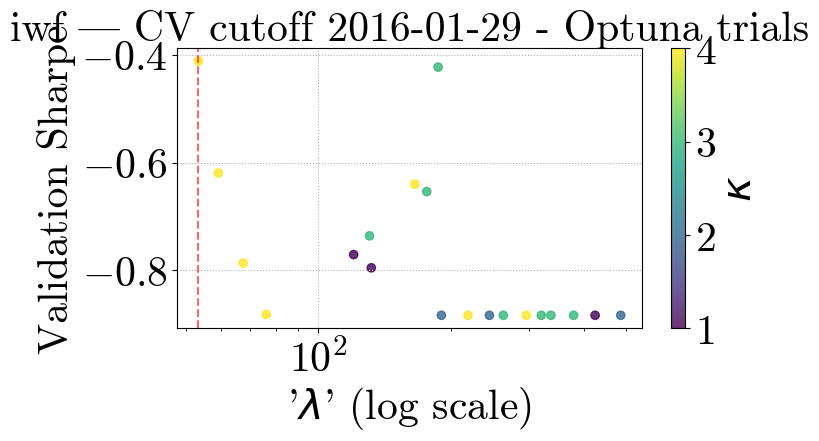

[I 2025-05-05 18:41:09,625] A new study created in memory with name: no-name-c9d1d985-9668-4e5b-998c-667480e24adc
[I 2025-05-05 18:41:13,191] Trial 0 finished with value: 1.523807174588965 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 1.523807174588965.
[I 2025-05-05 18:41:15,592] Trial 1 finished with value: 1.5238071745889652 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 1.5238071745889652.
[I 2025-05-05 18:41:17,501] Trial 2 finished with value: 1.523807174588965 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 1.5238071745889652.
[I 2025-05-05 18:41:22,252] Trial 3 finished with value: 0.932455575031229 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: 1.5238071745889652.
[I 2025-05-05 18:41:24,378] Trial 4 finished with value: 1.5238071745889652 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 1 with 

Optuna best λ=379.3973, κ=3, Sharpe=1.5238


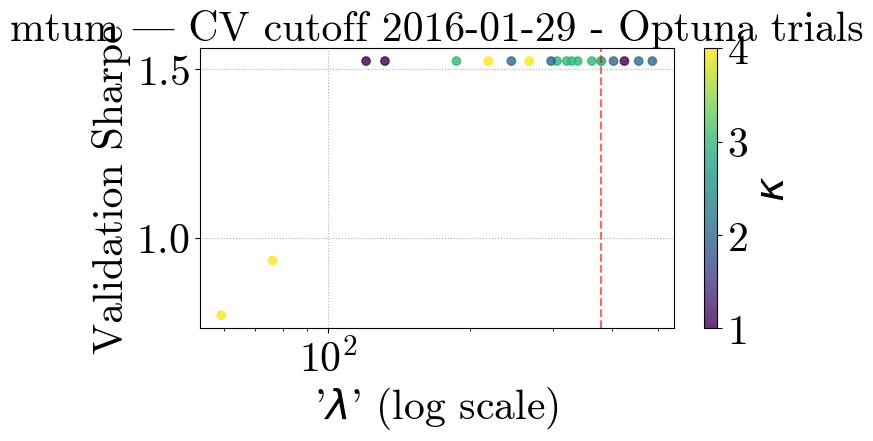

[I 2025-05-05 18:42:08,320] A new study created in memory with name: no-name-4198ea2c-2af6-4acf-905b-e947a9580327
[I 2025-05-05 18:42:11,472] Trial 0 finished with value: 0.1746957470718337 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.1746957470718337.
[I 2025-05-05 18:42:13,278] Trial 1 finished with value: -1.3030668994684087 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.1746957470718337.
[I 2025-05-05 18:42:14,857] Trial 2 finished with value: 0.298535458206271 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.298535458206271.
[I 2025-05-05 18:42:21,183] Trial 3 finished with value: 0.1000466970881875 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.298535458206271.
[I 2025-05-05 18:42:23,018] Trial 4 finished with value: -1.3030668994684087 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 2 wi

Optuna best λ=424.5992, κ=1, Sharpe=1.2841


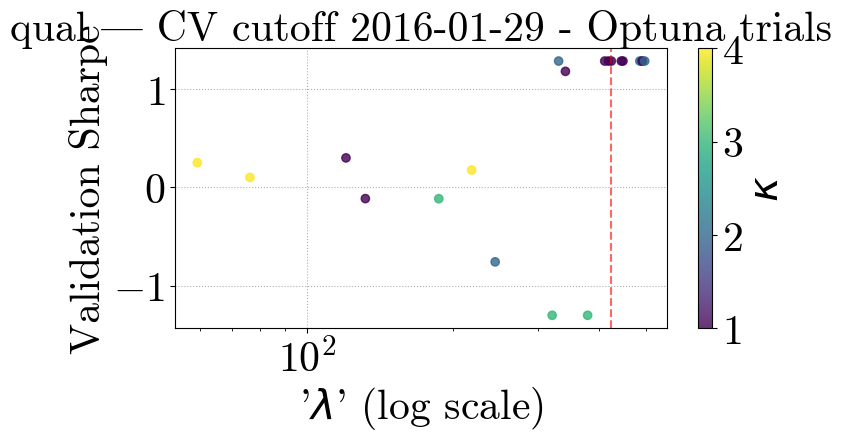

[I 2025-05-05 18:43:10,148] A new study created in memory with name: no-name-4e5b7f72-afbb-456a-b46d-03957d9dd7c3
[I 2025-05-05 18:43:13,217] Trial 0 finished with value: -0.39859968149573527 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.39859968149573527.
[I 2025-05-05 18:43:15,843] Trial 1 finished with value: -0.48341898230274105 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.39859968149573527.
[I 2025-05-05 18:43:18,665] Trial 2 finished with value: -0.321294530248559 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.321294530248559.
[I 2025-05-05 18:43:21,956] Trial 3 finished with value: -0.0755459807625282 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: -0.0755459807625282.
[I 2025-05-05 18:43:25,750] Trial 4 finished with value: -0.37275148717127504 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best 

Optuna best λ=170.1460, κ=4, Sharpe=0.0136


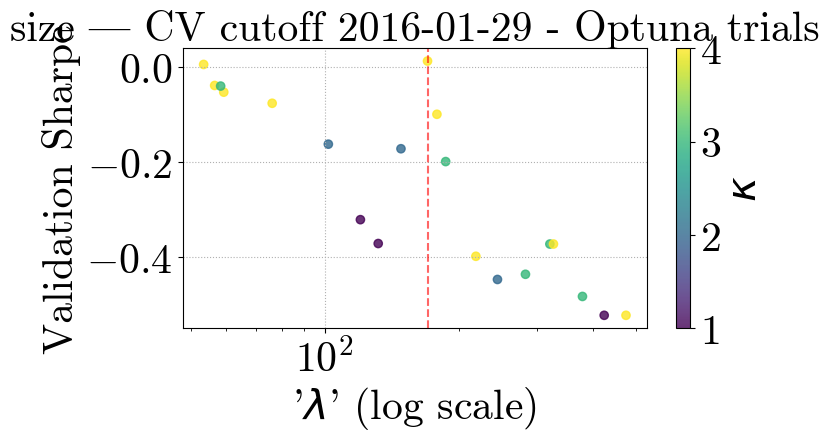

[I 2025-05-05 18:44:15,827] A new study created in memory with name: no-name-64fccdfc-965f-4115-99eb-e9a4528f36c5
[I 2025-05-05 18:44:18,216] Trial 0 finished with value: -0.3009735231964897 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.3009735231964897.
[I 2025-05-05 18:44:20,774] Trial 1 finished with value: -0.5977573919826558 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.3009735231964897.
[I 2025-05-05 18:44:22,935] Trial 2 finished with value: -0.5445793917022694 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.3009735231964897.
[I 2025-05-05 18:44:28,567] Trial 3 finished with value: 0.34590391846988683 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.34590391846988683.
[I 2025-05-05 18:44:31,286] Trial 4 finished with value: -0.5977573919826558 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is 

Optuna best λ=76.1376, κ=4, Sharpe=0.3459


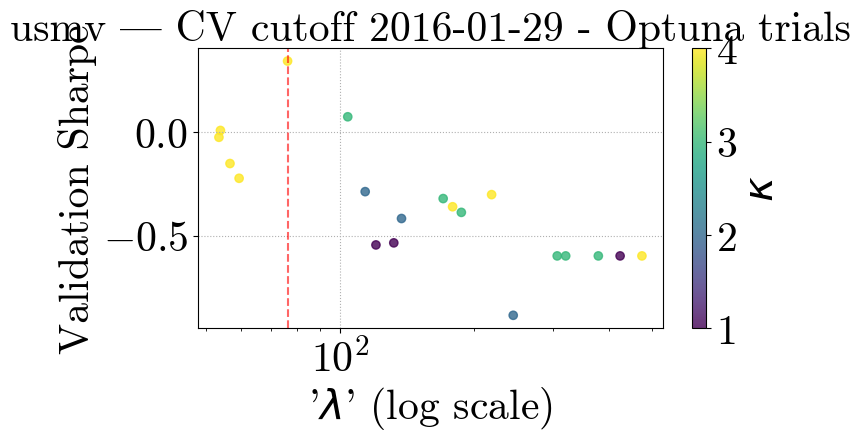

[I 2025-05-05 18:45:40,161] A new study created in memory with name: no-name-61f36b98-17c3-414a-8d55-3dec58dba914
[I 2025-05-05 18:45:42,451] Trial 0 finished with value: 1.2311674767243317 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 1.2311674767243317.
[I 2025-05-05 18:45:45,709] Trial 1 finished with value: 1.0989287881065617 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 1.2311674767243317.
[I 2025-05-05 18:45:47,148] Trial 2 finished with value: 1.1734608828909852 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: 1.2311674767243317.
[I 2025-05-05 18:45:49,602] Trial 3 finished with value: 1.1404019662318212 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 0 with value: 1.2311674767243317.
[I 2025-05-05 18:45:53,223] Trial 4 finished with value: 1.192943063842997 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 0 wi

Optuna best λ=222.3883, κ=2, Sharpe=1.3449


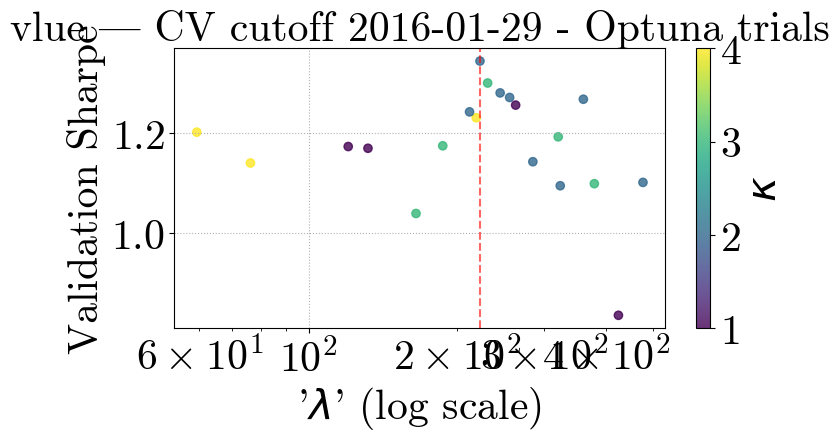

[I 2025-05-05 18:46:36,994] A new study created in memory with name: no-name-1769a273-8825-4507-a7c1-1bfa161660d1
[I 2025-05-05 18:46:42,012] Trial 0 finished with value: -0.41777959092077305 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.41777959092077305.
[I 2025-05-05 18:46:46,373] Trial 1 finished with value: -0.730563987147049 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.41777959092077305.
[I 2025-05-05 18:46:48,391] Trial 2 finished with value: -0.5241792560309814 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.41777959092077305.
[I 2025-05-05 18:46:53,072] Trial 3 finished with value: -0.9626065335841998 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 0 with value: -0.41777959092077305.
[I 2025-05-05 18:46:57,969] Trial 4 finished with value: -0.8119061944482384 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best

Optuna best λ=261.5787, κ=1, Sharpe=0.1503


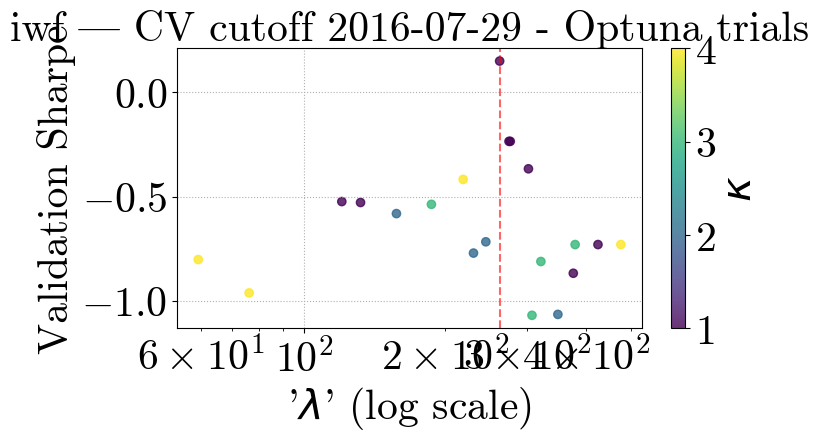

[I 2025-05-05 18:47:47,258] A new study created in memory with name: no-name-fdf6a083-67fa-44a8-834e-4d5febdc16cd
[I 2025-05-05 18:47:49,609] Trial 0 finished with value: 1.0747403766069936 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 1.0747403766069936.
[I 2025-05-05 18:47:52,361] Trial 1 finished with value: 1.1761137233486407 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 1.1761137233486407.
[I 2025-05-05 18:47:54,329] Trial 2 finished with value: 1.035705698566783 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 1.1761137233486407.
[I 2025-05-05 18:48:00,018] Trial 3 finished with value: 0.958909352220449 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: 1.1761137233486407.
[I 2025-05-05 18:48:02,497] Trial 4 finished with value: 1.3007721926322817 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 4 wit

Optuna best λ=176.3424, κ=3, Sharpe=1.5119


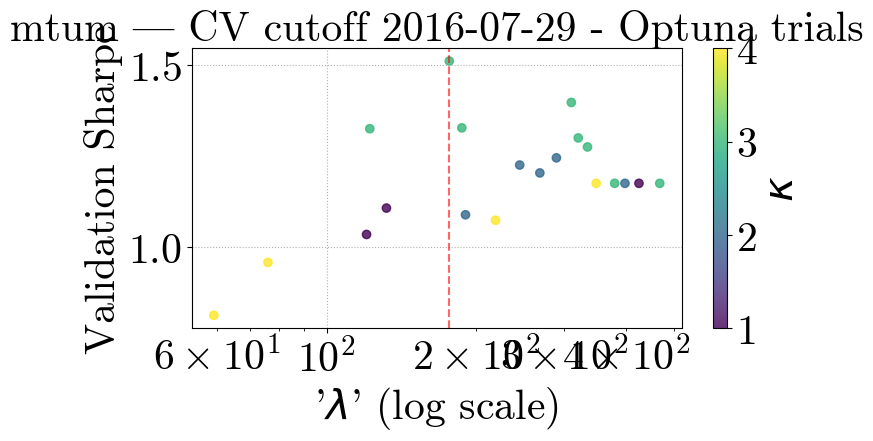

[I 2025-05-05 18:48:49,329] A new study created in memory with name: no-name-b288a82f-55d5-459e-9482-9fa2e90f6aba
[I 2025-05-05 18:48:52,416] Trial 0 finished with value: 0.10083722584228008 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.10083722584228008.
[I 2025-05-05 18:48:54,530] Trial 1 finished with value: -1.003270615272709 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.10083722584228008.
[I 2025-05-05 18:48:56,453] Trial 2 finished with value: 0.5186038360944585 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.5186038360944585.
[I 2025-05-05 18:49:01,136] Trial 3 finished with value: 0.28188181744864993 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.5186038360944585.
[I 2025-05-05 18:49:03,483] Trial 4 finished with value: -1.1521296317295413 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is tria

Optuna best λ=424.5992, κ=1, Sharpe=0.9853


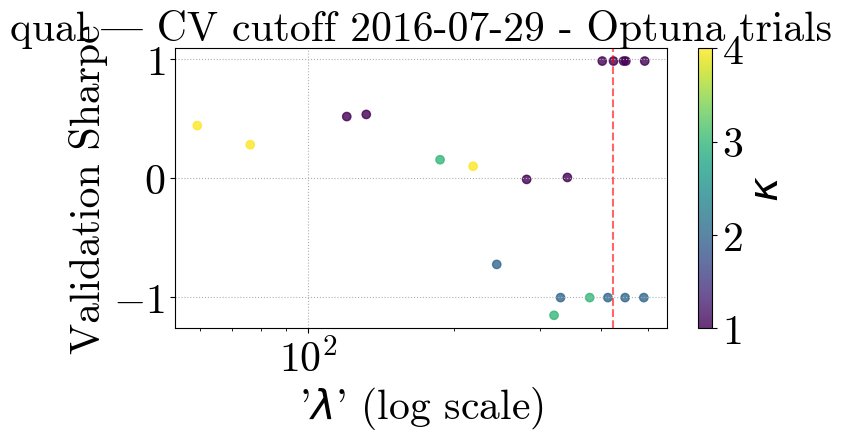

[I 2025-05-05 18:49:46,494] A new study created in memory with name: no-name-9b36f810-242e-4bca-aad6-906ef965bee6
[I 2025-05-05 18:49:50,929] Trial 0 finished with value: -0.15287659957491812 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.15287659957491812.
[I 2025-05-05 18:49:53,450] Trial 1 finished with value: -0.24047906085319237 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.15287659957491812.
[I 2025-05-05 18:49:56,153] Trial 2 finished with value: -0.48046489918902113 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.15287659957491812.
[I 2025-05-05 18:50:01,791] Trial 3 finished with value: 0.1459531082299641 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.1459531082299641.
[I 2025-05-05 18:50:06,193] Trial 4 finished with value: -0.33125266572824413 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Bes

Optuna best λ=76.1376, κ=4, Sharpe=0.1460


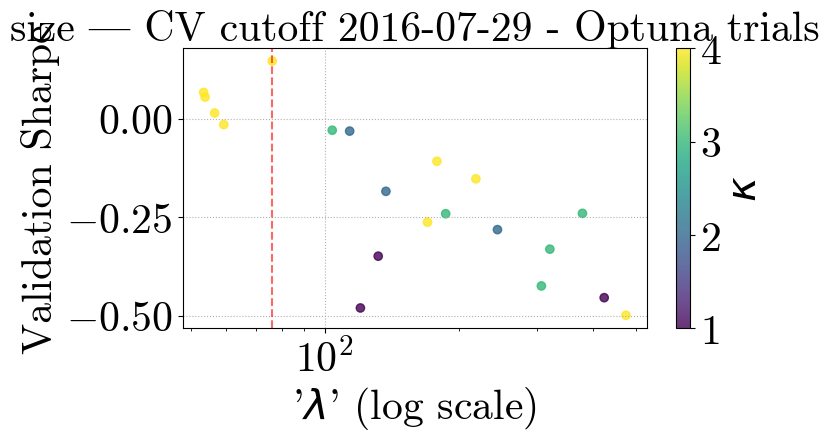

[I 2025-05-05 18:51:15,787] A new study created in memory with name: no-name-5cfb7c96-7eb3-41c8-8286-002b3f521464
[I 2025-05-05 18:51:18,472] Trial 0 finished with value: -0.1999915868692 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.1999915868692.
[I 2025-05-05 18:51:21,635] Trial 1 finished with value: -0.6393517814509033 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.1999915868692.
[I 2025-05-05 18:51:24,223] Trial 2 finished with value: -0.36185443905478704 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.1999915868692.
[I 2025-05-05 18:51:30,820] Trial 3 finished with value: 0.417855556210747 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.417855556210747.
[I 2025-05-05 18:51:33,718] Trial 4 finished with value: -0.9925830374404084 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 with va

Optuna best λ=76.1376, κ=4, Sharpe=0.4179


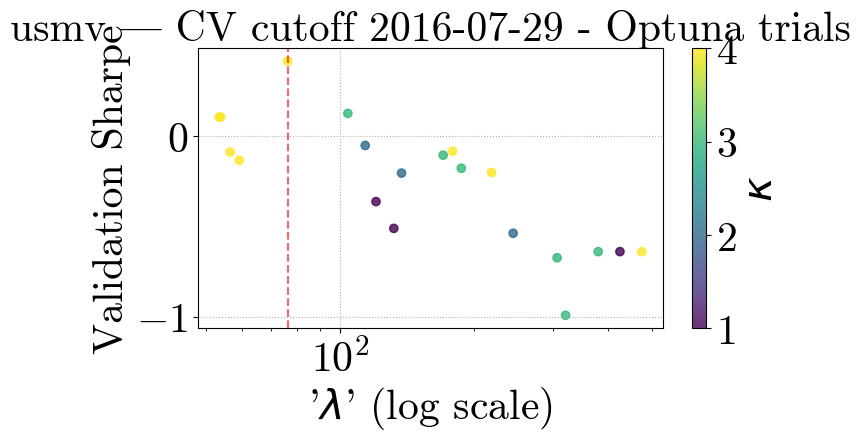

[I 2025-05-05 18:52:47,724] A new study created in memory with name: no-name-094626e3-5413-458d-ab17-17e675a86953
[I 2025-05-05 18:52:51,553] Trial 0 finished with value: 0.1893735374140178 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.1893735374140178.
[I 2025-05-05 18:52:54,898] Trial 1 finished with value: 0.47021176083192734 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 0.47021176083192734.
[I 2025-05-05 18:52:56,898] Trial 2 finished with value: 0.4629207792056899 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 0.47021176083192734.
[I 2025-05-05 18:53:00,414] Trial 3 finished with value: 0.0747515372786658 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: 0.47021176083192734.
[I 2025-05-05 18:53:03,950] Trial 4 finished with value: 0.11665542635843477 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is tria

Optuna best λ=390.5443, κ=2, Sharpe=0.5340


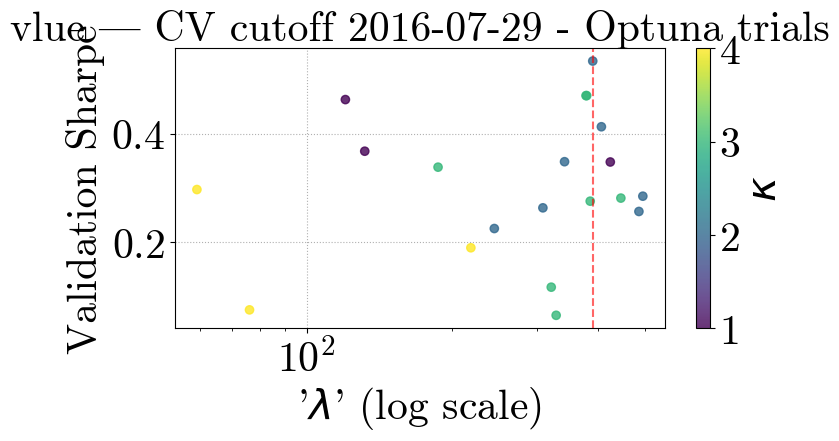

[I 2025-05-05 18:53:57,060] A new study created in memory with name: no-name-1c6f3afb-545b-4bdc-af6d-c81d46f4a4ab
[I 2025-05-05 18:54:00,917] Trial 0 finished with value: -0.38429029337086784 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.38429029337086784.
[I 2025-05-05 18:54:05,286] Trial 1 finished with value: -0.4438220619770735 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.38429029337086784.
[I 2025-05-05 18:54:07,187] Trial 2 finished with value: -0.24316465154712585 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.24316465154712585.
[I 2025-05-05 18:54:10,538] Trial 3 finished with value: -1.0478346630504138 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: -0.24316465154712585.
[I 2025-05-05 18:54:15,200] Trial 4 finished with value: -0.6161927572761303 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Be

Optuna best λ=190.1054, κ=2, Sharpe=-0.0408


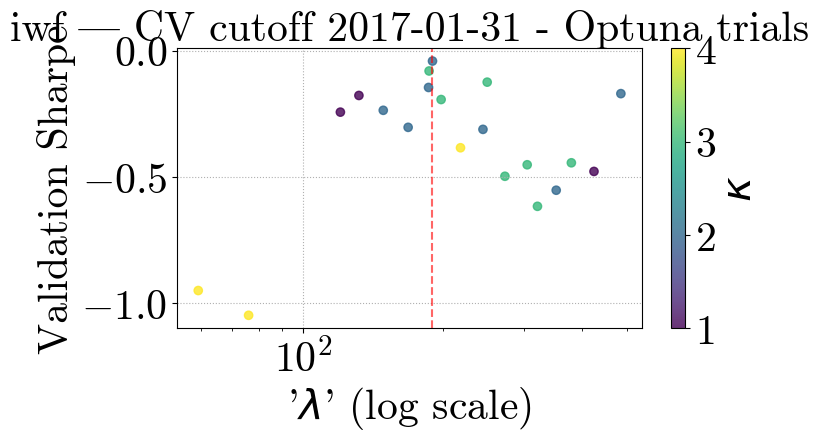

[I 2025-05-05 18:55:27,232] A new study created in memory with name: no-name-6d25b7d7-1da0-4f25-afcb-2e581a5c75fe
[I 2025-05-05 18:55:31,004] Trial 0 finished with value: 0.5306946511363458 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.5306946511363458.
[I 2025-05-05 18:55:33,533] Trial 1 finished with value: 0.728550374850522 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 0.728550374850522.
[I 2025-05-05 18:55:35,525] Trial 2 finished with value: 0.5990158959692992 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 0.728550374850522.
[I 2025-05-05 18:55:41,077] Trial 3 finished with value: 0.9401050596502006 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.9401050596502006.
[I 2025-05-05 18:55:43,751] Trial 4 finished with value: 1.0182571352642928 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 4 with

Optuna best λ=178.6344, κ=4, Sharpe=1.1314


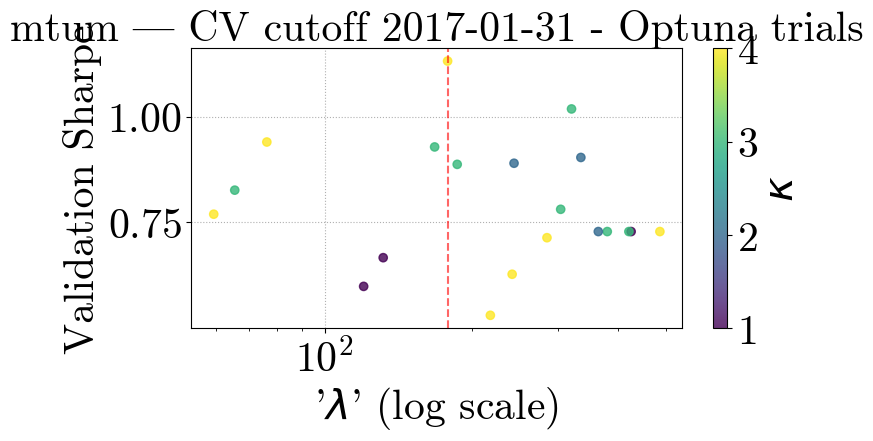

[I 2025-05-05 18:56:37,450] A new study created in memory with name: no-name-43c166c9-e5c4-4d3e-9c23-881071fd0469
[I 2025-05-05 18:56:41,126] Trial 0 finished with value: 0.36043520360220693 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.36043520360220693.
[I 2025-05-05 18:56:44,051] Trial 1 finished with value: -0.6551736832562959 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.36043520360220693.
[I 2025-05-05 18:56:46,100] Trial 2 finished with value: 0.6155304122728589 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.6155304122728589.
[I 2025-05-05 18:56:50,272] Trial 3 finished with value: 0.17433735502823022 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.6155304122728589.
[I 2025-05-05 18:56:53,529] Trial 4 finished with value: -0.9706402170187978 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is tri

Optuna best λ=490.0982, κ=2, Sharpe=0.6379


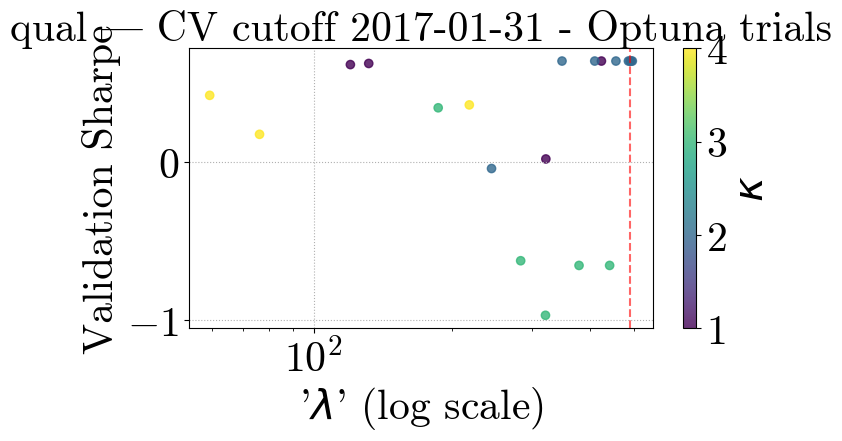

[I 2025-05-05 18:57:39,504] A new study created in memory with name: no-name-c90c2021-0cea-4aaa-b401-4546c3b9bc42
[I 2025-05-05 18:57:43,966] Trial 0 finished with value: -0.09546728155658035 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.09546728155658035.
[I 2025-05-05 18:57:46,973] Trial 1 finished with value: -0.34356864858133374 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.09546728155658035.
[I 2025-05-05 18:57:49,869] Trial 2 finished with value: -0.3951231043770048 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.09546728155658035.
[I 2025-05-05 18:57:54,645] Trial 3 finished with value: 0.1245283222474844 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.1245283222474844.
[I 2025-05-05 18:57:57,992] Trial 4 finished with value: -0.5272273110134993 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best 

Optuna best λ=53.3963, κ=4, Sharpe=0.2507


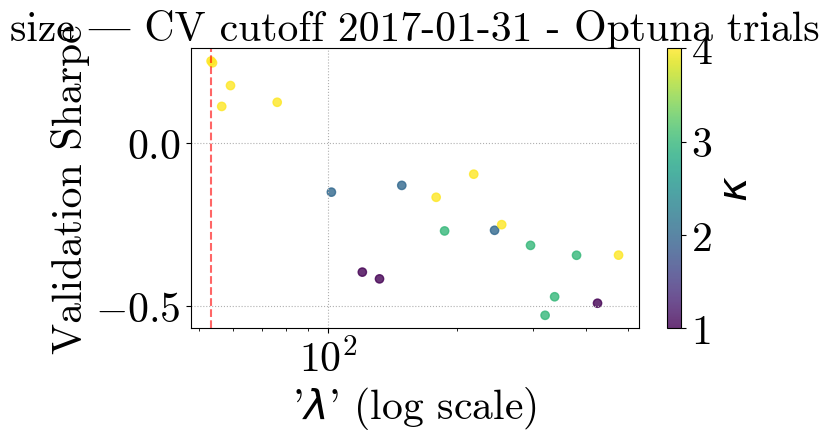

[I 2025-05-05 18:59:03,201] A new study created in memory with name: no-name-b9721e95-390e-4670-9b54-0d4d78b2623f
[I 2025-05-05 18:59:06,834] Trial 0 finished with value: -0.590720158942795 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.590720158942795.
[I 2025-05-05 18:59:09,601] Trial 1 finished with value: -1.032863273348094 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.590720158942795.
[I 2025-05-05 18:59:12,232] Trial 2 finished with value: -0.46321164797092834 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.46321164797092834.
[I 2025-05-05 18:59:18,014] Trial 3 finished with value: -0.07380332803634815 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: -0.07380332803634815.
[I 2025-05-05 18:59:20,824] Trial 4 finished with value: -1.2004480767934287 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is 

Optuna best λ=76.1376, κ=4, Sharpe=-0.0738


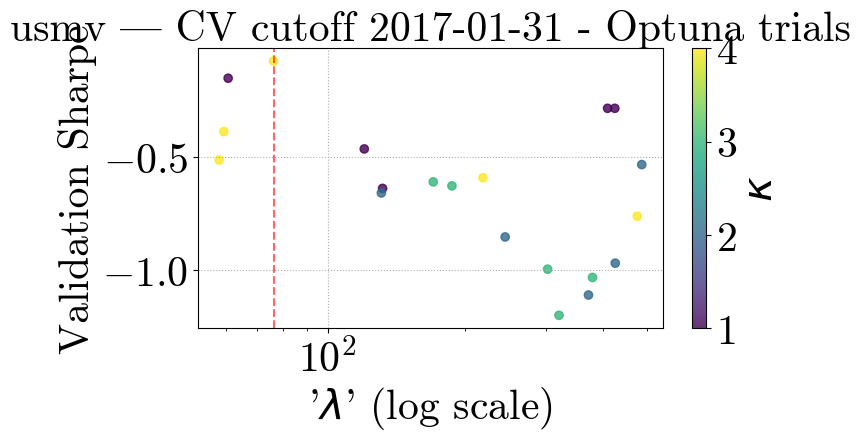

[I 2025-05-05 19:00:17,588] A new study created in memory with name: no-name-86ee3b9d-13a3-40fa-a09c-e7f4cb524c4a
[I 2025-05-05 19:00:21,296] Trial 0 finished with value: 0.6973473796593097 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.6973473796593097.
[I 2025-05-05 19:00:24,867] Trial 1 finished with value: 0.9838386548442295 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 0.9838386548442295.
[I 2025-05-05 19:00:27,019] Trial 2 finished with value: 0.9380449939686946 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 0.9838386548442295.
[I 2025-05-05 19:00:30,548] Trial 3 finished with value: 0.6146217845642257 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: 0.9838386548442295.
[I 2025-05-05 19:00:33,232] Trial 4 finished with value: 0.6515374724472012 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 1 w

Optuna best λ=378.2098, κ=3, Sharpe=1.0156


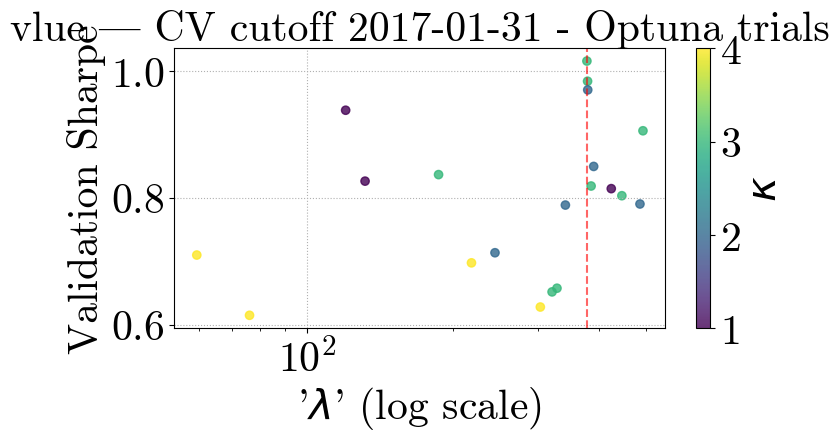

[I 2025-05-05 19:01:24,326] A new study created in memory with name: no-name-418c177f-c35b-4a77-be86-3b6616a7f614
[I 2025-05-05 19:01:28,126] Trial 0 finished with value: -0.7041642113492351 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.7041642113492351.
[I 2025-05-05 19:01:33,557] Trial 1 finished with value: -0.9494671117941446 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.7041642113492351.
[I 2025-05-05 19:01:35,694] Trial 2 finished with value: -0.4708425868201148 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.4708425868201148.
[I 2025-05-05 19:01:40,271] Trial 3 finished with value: -1.4537475589824307 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: -0.4708425868201148.
[I 2025-05-05 19:01:45,761] Trial 4 finished with value: -0.732650757606233 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is t

Optuna best λ=304.5259, κ=1, Sharpe=-0.1312


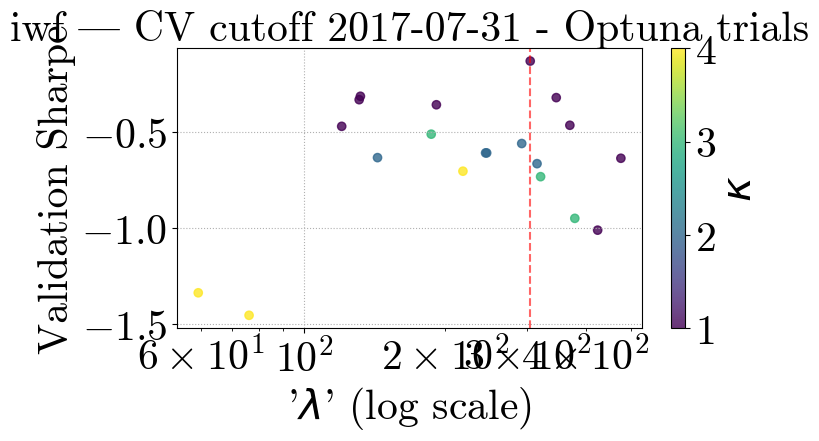

[I 2025-05-05 19:02:33,226] A new study created in memory with name: no-name-b403232d-7a92-4c76-a981-b91f4dce7c4c
[I 2025-05-05 19:02:36,905] Trial 0 finished with value: 1.018024611986269 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 1.018024611986269.
[I 2025-05-05 19:02:39,388] Trial 1 finished with value: 1.2241679198414144 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 1.2241679198414144.
[I 2025-05-05 19:02:41,816] Trial 2 finished with value: 1.0415061048854715 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 1.2241679198414144.
[I 2025-05-05 19:02:47,662] Trial 3 finished with value: 1.8968139537615811 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 1.8968139537615811.
[I 2025-05-05 19:02:50,811] Trial 4 finished with value: 1.2671585352162036 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 wit

Optuna best λ=53.3963, κ=4, Sharpe=1.9125


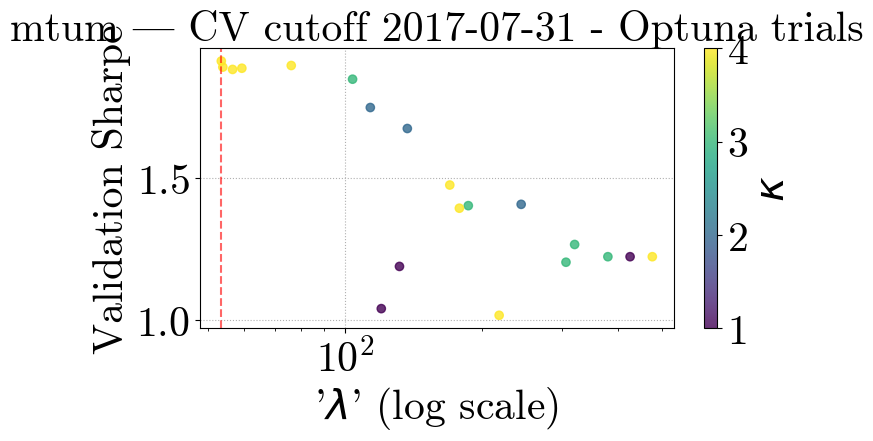

[I 2025-05-05 19:04:08,651] A new study created in memory with name: no-name-fdd3be8f-4001-4129-a3ce-e0001ef74c8d
[I 2025-05-05 19:04:14,565] Trial 0 finished with value: 0.3805357994809818 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.3805357994809818.
[I 2025-05-05 19:04:18,193] Trial 1 finished with value: -0.7378163880806663 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.3805357994809818.
[I 2025-05-05 19:04:20,671] Trial 2 finished with value: 0.5328933292827249 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.5328933292827249.
[I 2025-05-05 19:04:27,117] Trial 3 finished with value: 0.1862593103703903 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.5328933292827249.
[I 2025-05-05 19:04:30,867] Trial 4 finished with value: -0.8587547398026878 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 2

Optuna best λ=424.5992, κ=1, Sharpe=0.7208


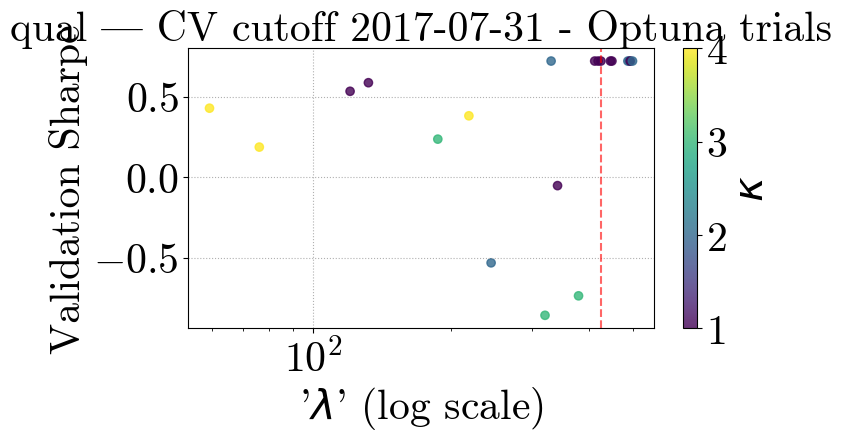

[I 2025-05-05 19:05:15,005] A new study created in memory with name: no-name-739b1bf8-f2c3-4e75-a429-aaa06d982b57
[I 2025-05-05 19:05:19,232] Trial 0 finished with value: 0.3699191248642487 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.3699191248642487.
[I 2025-05-05 19:05:22,789] Trial 1 finished with value: 0.28618333952212527 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.3699191248642487.
[I 2025-05-05 19:05:24,811] Trial 2 finished with value: 0.31604114265251393 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: 0.3699191248642487.
[I 2025-05-05 19:05:30,667] Trial 3 finished with value: 0.5928580678958812 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.5928580678958812.
[I 2025-05-05 19:05:34,220] Trial 4 finished with value: 0.18676980602167012 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 

Optuna best λ=76.1376, κ=4, Sharpe=0.5929


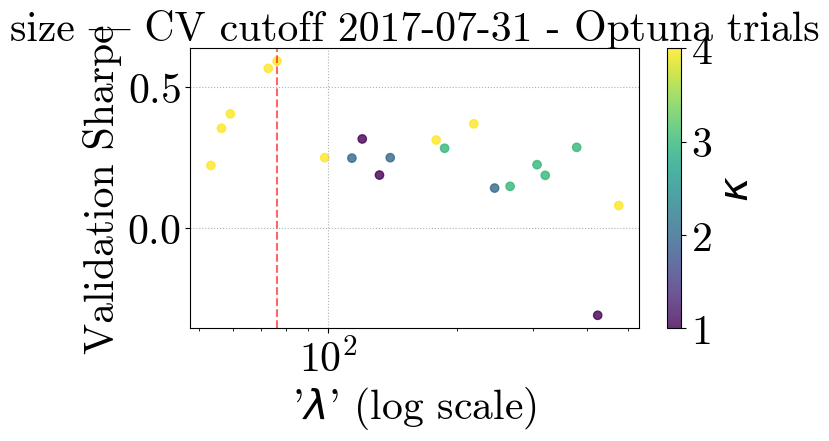

[I 2025-05-05 19:06:35,206] A new study created in memory with name: no-name-786c023f-36b3-49c8-b981-c537efcceeaf
[I 2025-05-05 19:06:39,143] Trial 0 finished with value: -0.5068660983365647 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.5068660983365647.
[I 2025-05-05 19:06:41,509] Trial 1 finished with value: -1.0362587538974268 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.5068660983365647.
[I 2025-05-05 19:06:44,149] Trial 2 finished with value: -0.5290687410671303 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: -0.5068660983365647.
[I 2025-05-05 19:06:49,546] Trial 3 finished with value: -0.07205528620345285 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: -0.07205528620345285.
[I 2025-05-05 19:06:52,060] Trial 4 finished with value: -0.891581927586509 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is

Optuna best λ=72.6402, κ=4, Sharpe=-0.0175


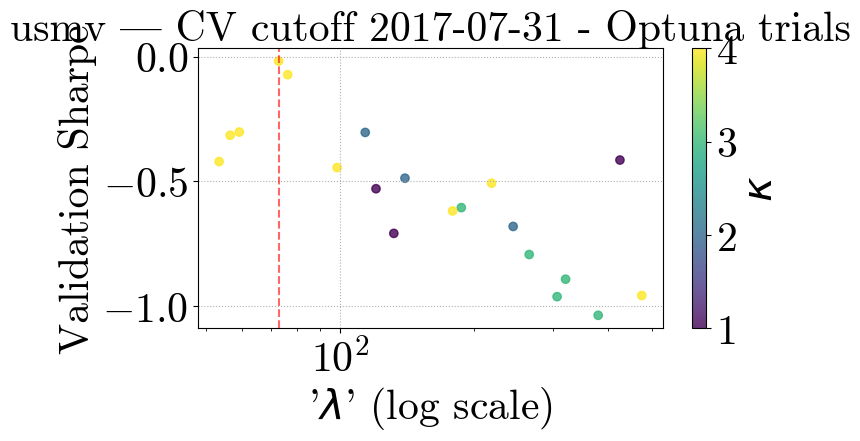

[I 2025-05-05 19:08:15,085] A new study created in memory with name: no-name-216b976f-072f-45c8-a532-3dd0dc2646af
[I 2025-05-05 19:08:17,857] Trial 0 finished with value: 0.10466020316618845 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.10466020316618845.
[I 2025-05-05 19:08:20,617] Trial 1 finished with value: 0.38797669896119547 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 0.38797669896119547.
[I 2025-05-05 19:08:22,959] Trial 2 finished with value: 0.37155518416697025 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 0.38797669896119547.
[I 2025-05-05 19:08:26,049] Trial 3 finished with value: -0.023209485451828663 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: 0.38797669896119547.
[I 2025-05-05 19:08:28,680] Trial 4 finished with value: 0.07010836878049127 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best i

Optuna best λ=385.8500, κ=3, Sharpe=0.4617


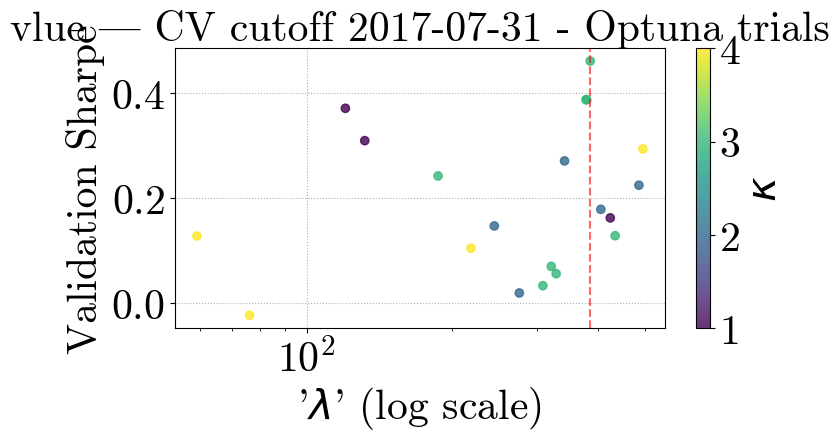

[I 2025-05-05 19:09:15,817] A new study created in memory with name: no-name-c92f6519-c544-4655-bbce-7f55e6fde283
[I 2025-05-05 19:09:20,814] Trial 0 finished with value: -0.4932345542760791 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.4932345542760791.
[I 2025-05-05 19:09:24,404] Trial 1 finished with value: -0.330618248494144 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: -0.330618248494144.
[I 2025-05-05 19:09:27,031] Trial 2 finished with value: -0.6648868746643715 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: -0.330618248494144.
[I 2025-05-05 19:09:31,835] Trial 3 finished with value: -1.6903312371625132 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 1 with value: -0.330618248494144.
[I 2025-05-05 19:09:35,653] Trial 4 finished with value: -0.3860238930915531 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is tria

Optuna best λ=362.1651, κ=3, Sharpe=-0.2571


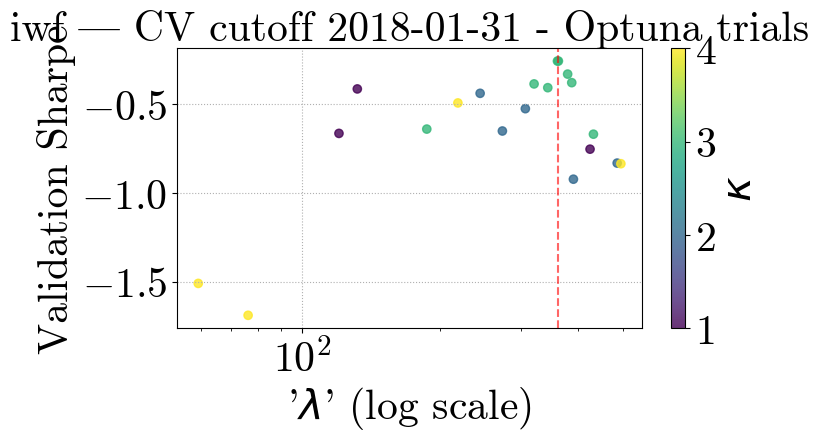

[I 2025-05-05 19:10:32,240] A new study created in memory with name: no-name-5799010b-611e-4499-b120-262e148104ca
[I 2025-05-05 19:10:35,312] Trial 0 finished with value: 1.3129901897751353 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 1.3129901897751353.
[I 2025-05-05 19:10:37,884] Trial 1 finished with value: 1.3641644415664627 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 1.3641644415664627.
[I 2025-05-05 19:10:40,499] Trial 2 finished with value: 1.445399656101793 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 1.445399656101793.
[I 2025-05-05 19:10:48,441] Trial 3 finished with value: 2.0280331058728027 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 2.0280331058728027.
[I 2025-05-05 19:10:50,882] Trial 4 finished with value: 1.5021885831787423 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 wit

Optuna best λ=56.5327, κ=4, Sharpe=2.2845


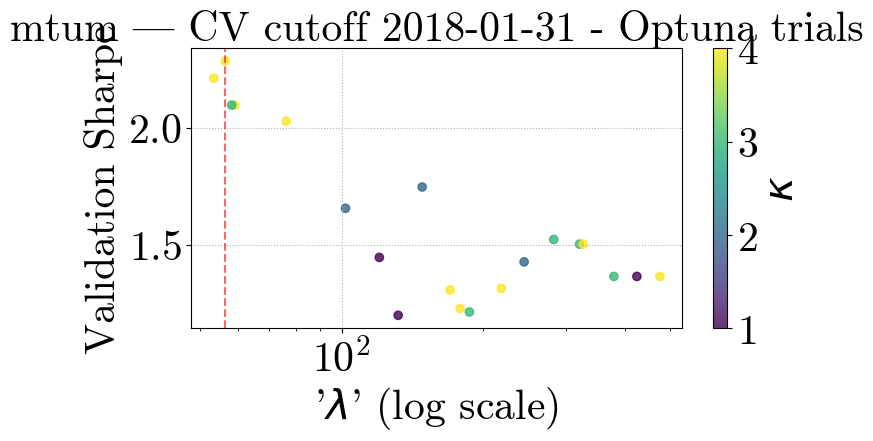

[I 2025-05-05 19:12:10,576] A new study created in memory with name: no-name-81af8f3c-1c72-4b87-ac00-66bfda3c9748
[I 2025-05-05 19:12:16,661] Trial 0 finished with value: 0.4096311103795585 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.4096311103795585.
[I 2025-05-05 19:12:20,431] Trial 1 finished with value: -0.6393809998280168 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.4096311103795585.
[I 2025-05-05 19:12:23,205] Trial 2 finished with value: 0.5572039116681021 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.5572039116681021.
[I 2025-05-05 19:12:28,603] Trial 3 finished with value: 0.2523338653051359 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.5572039116681021.
[I 2025-05-05 19:12:32,461] Trial 4 finished with value: -0.5206152755980408 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 2

Optuna best λ=424.5992, κ=1, Sharpe=1.1103


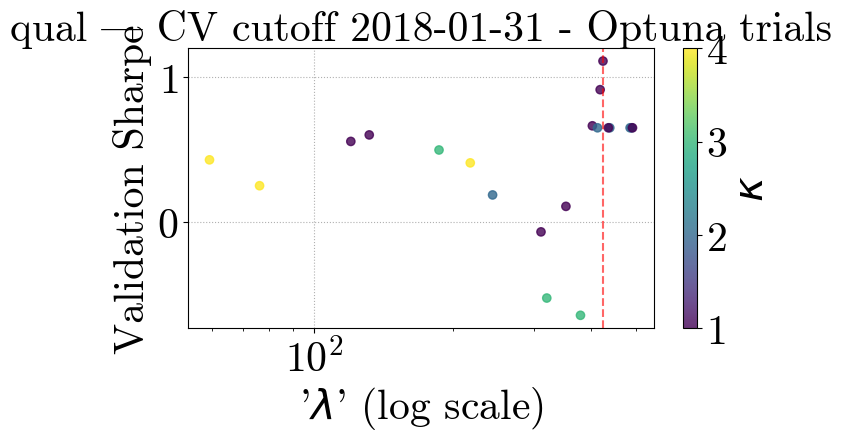

[I 2025-05-05 19:13:24,932] A new study created in memory with name: no-name-81948892-8405-4d14-91d6-5e17776b0ca6
[I 2025-05-05 19:13:29,119] Trial 0 finished with value: 0.03139654147058214 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.03139654147058214.
[I 2025-05-05 19:13:31,726] Trial 1 finished with value: -0.10678423004746013 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.03139654147058214.
[I 2025-05-05 19:13:33,774] Trial 2 finished with value: 0.022076824708074438 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: 0.03139654147058214.
[I 2025-05-05 19:13:39,013] Trial 3 finished with value: 0.2857370512867935 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.2857370512867935.
[I 2025-05-05 19:13:42,170] Trial 4 finished with value: 0.011725462203248944 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is

Optuna best λ=76.1376, κ=4, Sharpe=0.2857


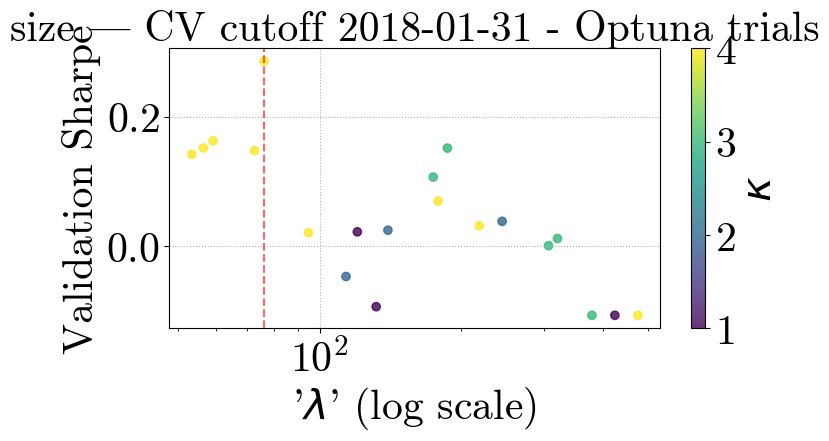

[I 2025-05-05 19:14:55,248] A new study created in memory with name: no-name-7f7f5d11-ed1c-4367-9fa7-2868adbe45c1
[I 2025-05-05 19:15:00,538] Trial 0 finished with value: -0.397076848718288 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.397076848718288.
[I 2025-05-05 19:15:02,872] Trial 1 finished with value: -0.744343600719733 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.397076848718288.
[I 2025-05-05 19:15:05,390] Trial 2 finished with value: -0.230491306829004 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.230491306829004.
[I 2025-05-05 19:15:11,645] Trial 3 finished with value: 0.09407424834046305 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.09407424834046305.
[I 2025-05-05 19:15:14,301] Trial 4 finished with value: -0.6774670366402933 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 

Optuna best λ=53.3963, κ=4, Sharpe=0.1825


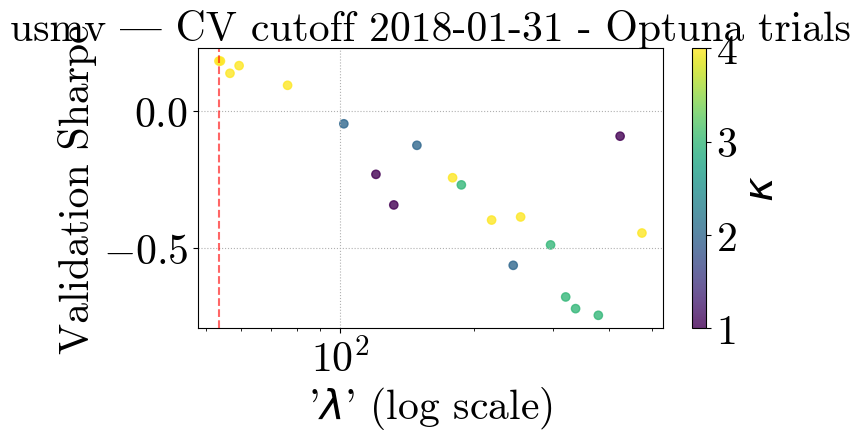

[I 2025-05-05 19:16:25,829] A new study created in memory with name: no-name-2425c81a-5d1d-4df0-8b5e-6cdf0a210b12
[I 2025-05-05 19:16:29,736] Trial 0 finished with value: 0.5416920179413728 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.5416920179413728.
[I 2025-05-05 19:16:33,141] Trial 1 finished with value: 0.18951225592470575 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.5416920179413728.
[I 2025-05-05 19:16:35,193] Trial 2 finished with value: 0.6289885730725712 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.6289885730725712.
[I 2025-05-05 19:16:39,000] Trial 3 finished with value: 0.25801195287163997 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.6289885730725712.
[I 2025-05-05 19:16:43,469] Trial 4 finished with value: 0.34356165924071297 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 

Optuna best λ=475.3114, κ=2, Sharpe=0.7144


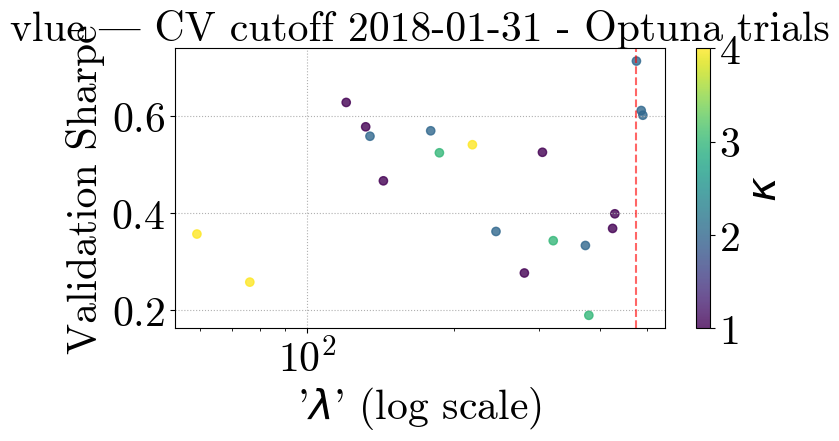

[I 2025-05-05 19:17:30,057] A new study created in memory with name: no-name-73e5ef6f-ff6e-4974-bf88-6e27d653f9ca
[I 2025-05-05 19:17:32,665] Trial 0 finished with value: 0.008269356779701484 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.008269356779701484.
[I 2025-05-05 19:17:35,507] Trial 1 finished with value: -0.3987306326986233 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.008269356779701484.
[I 2025-05-05 19:17:37,759] Trial 2 finished with value: 0.047420170220944136 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.047420170220944136.
[I 2025-05-05 19:17:42,919] Trial 3 finished with value: 0.9173992947653006 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.9173992947653006.
[I 2025-05-05 19:17:46,613] Trial 4 finished with value: -0.13794437755551575 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best

Optuna best λ=76.1376, κ=4, Sharpe=0.9174


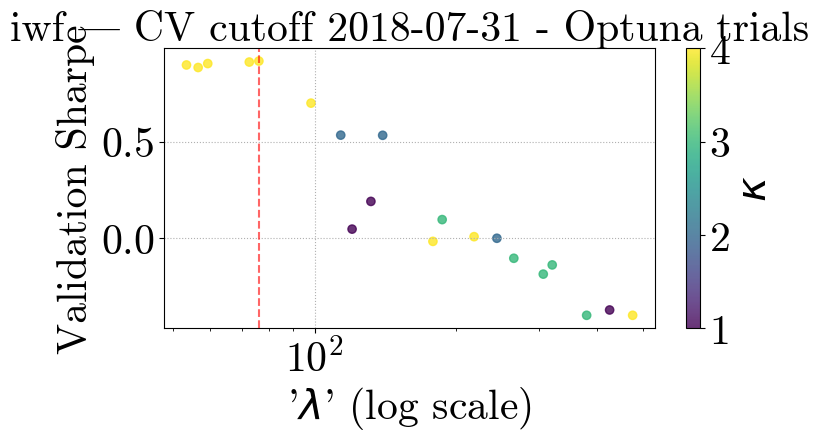

[I 2025-05-05 19:18:54,460] A new study created in memory with name: no-name-4f88c58f-129b-4479-b1f5-9876b2205f6f
[I 2025-05-05 19:18:57,813] Trial 0 finished with value: 0.975260424893631 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.975260424893631.
[I 2025-05-05 19:19:00,293] Trial 1 finished with value: 1.0357049337891024 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 1.0357049337891024.
[I 2025-05-05 19:19:02,832] Trial 2 finished with value: 1.125862235065434 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 1.125862235065434.
[I 2025-05-05 19:19:07,476] Trial 3 finished with value: 1.4257961091848346 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 1.4257961091848346.
[I 2025-05-05 19:19:09,937] Trial 4 finished with value: 1.0297942720057165 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 with 

Optuna best λ=53.3963, κ=4, Sharpe=1.5501


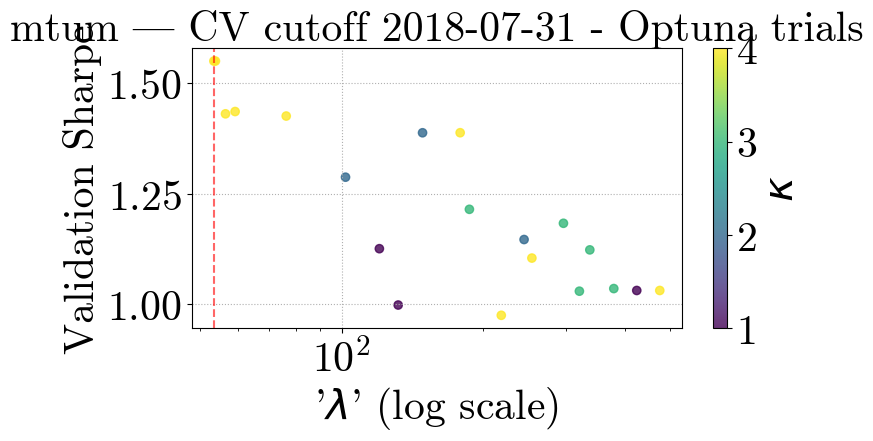

[I 2025-05-05 19:20:17,827] A new study created in memory with name: no-name-746c05c3-db0d-46ce-839e-810a4b89c8ab
[I 2025-05-05 19:20:23,297] Trial 0 finished with value: 0.48654398455775993 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.48654398455775993.
[I 2025-05-05 19:20:25,921] Trial 1 finished with value: 0.45715484506004617 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.48654398455775993.
[I 2025-05-05 19:20:28,337] Trial 2 finished with value: 0.5948762879456491 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.5948762879456491.
[I 2025-05-05 19:20:34,881] Trial 3 finished with value: 0.04726652506332541 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.5948762879456491.
[I 2025-05-05 19:20:38,479] Trial 4 finished with value: 0.567659249140637 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial

Optuna best λ=424.5992, κ=1, Sharpe=0.7814


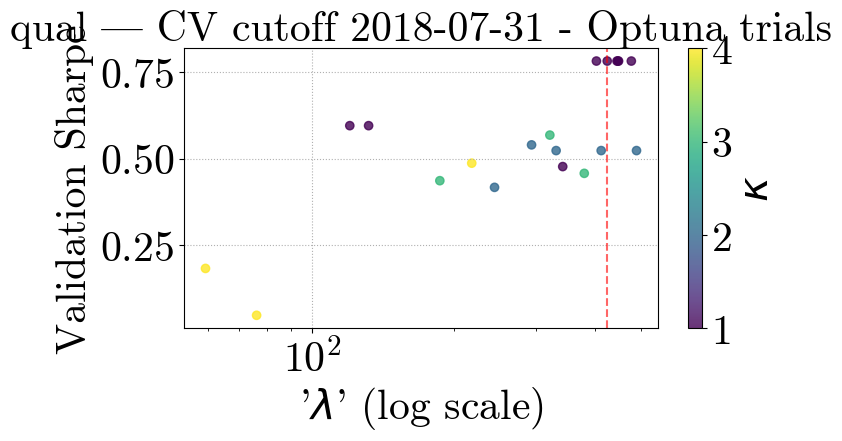

[I 2025-05-05 19:21:28,824] A new study created in memory with name: no-name-c49dcdef-f0c2-4314-8e7e-0def5d3025e3
[I 2025-05-05 19:21:32,456] Trial 0 finished with value: 0.18717135321537667 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.18717135321537667.
[I 2025-05-05 19:21:34,914] Trial 1 finished with value: -0.358827108732753 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.18717135321537667.
[I 2025-05-05 19:21:37,668] Trial 2 finished with value: 0.17755121971493873 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: 0.18717135321537667.
[I 2025-05-05 19:21:42,748] Trial 3 finished with value: 0.00010316748044392324 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 0 with value: 0.18717135321537667.
[I 2025-05-05 19:21:44,931] Trial 4 finished with value: -0.05757299318446031 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best 

Optuna best λ=218.5431, κ=4, Sharpe=0.1872


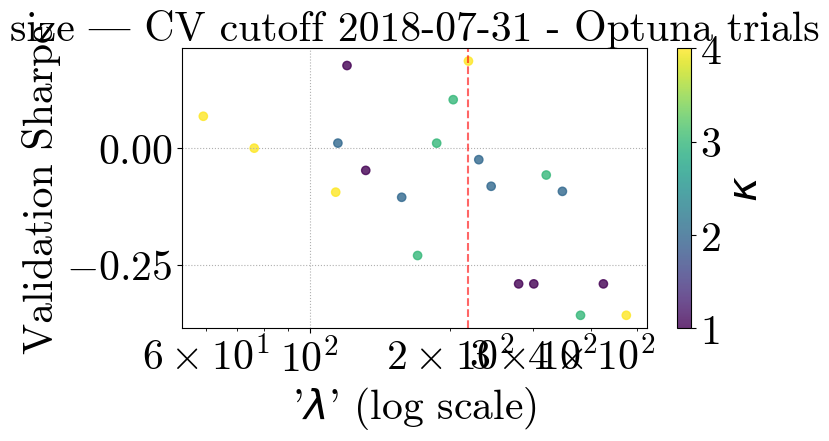

[I 2025-05-05 19:22:46,829] A new study created in memory with name: no-name-eba4b892-d338-44d9-ae4b-05a01552f1ff
[I 2025-05-05 19:22:50,214] Trial 0 finished with value: -0.30676074082241966 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: -0.30676074082241966.
[I 2025-05-05 19:22:53,804] Trial 1 finished with value: -0.8232754909538599 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: -0.30676074082241966.
[I 2025-05-05 19:22:55,691] Trial 2 finished with value: -0.26094609280470676 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: -0.26094609280470676.
[I 2025-05-05 19:23:02,922] Trial 3 finished with value: -0.6775553062653569 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: -0.26094609280470676.
[I 2025-05-05 19:23:06,301] Trial 4 finished with value: -0.4458100751251369 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Be

Optuna best λ=424.5992, κ=1, Sharpe=-0.0073


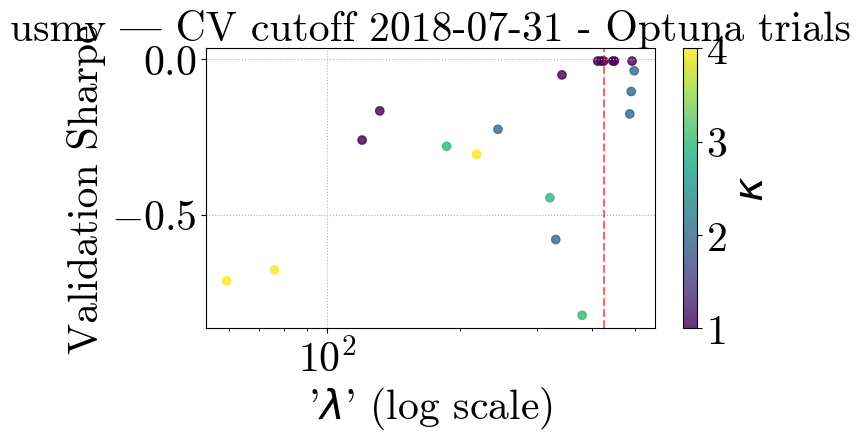

[I 2025-05-05 19:23:43,390] A new study created in memory with name: no-name-0e2261f1-cd8d-4933-b128-383b7920661d
[I 2025-05-05 19:23:46,244] Trial 0 finished with value: 0.6863864487223118 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.6863864487223118.
[I 2025-05-05 19:23:49,372] Trial 1 finished with value: 0.4198745874978862 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.6863864487223118.
[I 2025-05-05 19:23:51,234] Trial 2 finished with value: 0.7307025317811605 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 2 with value: 0.7307025317811605.
[I 2025-05-05 19:23:54,489] Trial 3 finished with value: 0.2300700923355017 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 2 with value: 0.7307025317811605.
[I 2025-05-05 19:23:57,373] Trial 4 finished with value: 0.45873293668862025 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 2 

Optuna best λ=153.5094, κ=2, Sharpe=0.8780


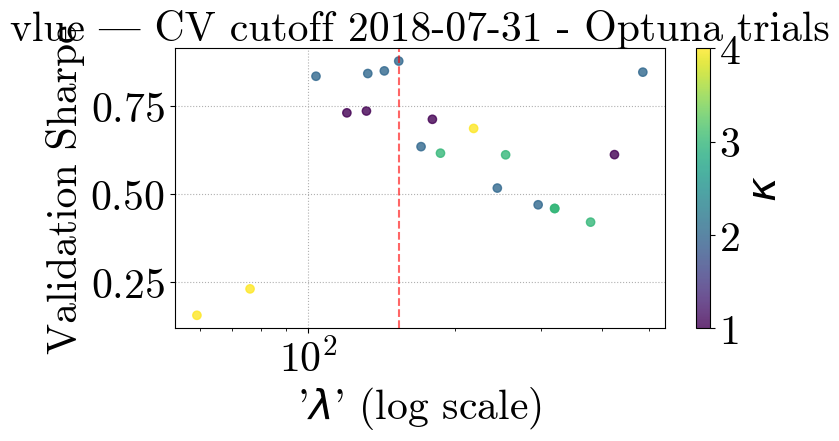

[I 2025-05-05 19:24:51,065] A new study created in memory with name: no-name-ffebcb06-f1db-45f6-8b1f-6f0867c2e0bc
[I 2025-05-05 19:24:54,695] Trial 0 finished with value: 0.030602268759156 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.030602268759156.
[I 2025-05-05 19:24:57,390] Trial 1 finished with value: 0.3604749017098079 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 1 with value: 0.3604749017098079.
[I 2025-05-05 19:24:59,637] Trial 2 finished with value: 0.29188737760310207 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 1 with value: 0.3604749017098079.
[I 2025-05-05 19:25:06,841] Trial 3 finished with value: 0.8212236530702978 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 0.8212236530702978.
[I 2025-05-05 19:25:09,448] Trial 4 finished with value: 0.07325055080447607 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 w

Optuna best λ=76.1376, κ=4, Sharpe=0.8212


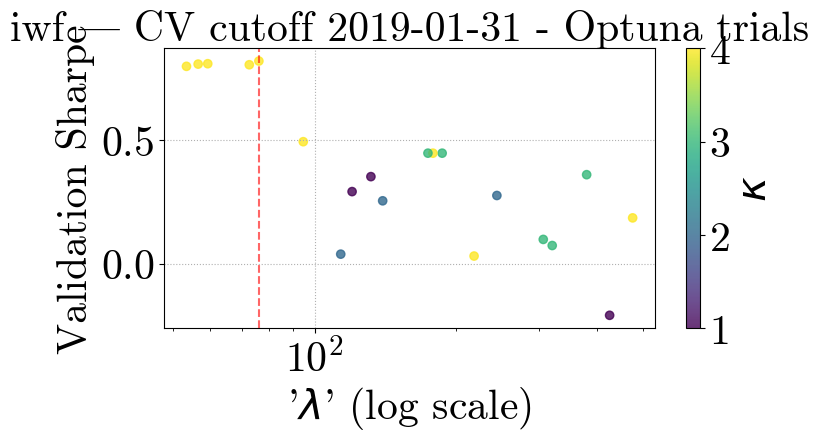

[I 2025-05-05 19:26:22,946] A new study created in memory with name: no-name-13e55fbb-c089-4fde-9837-9c5936593d0e
[I 2025-05-05 19:26:26,536] Trial 0 finished with value: 0.9227234733882372 and parameters: {'lambda': 218.5430534813131, 'kappa': 4}. Best is trial 0 with value: 0.9227234733882372.
[I 2025-05-05 19:26:28,853] Trial 1 finished with value: 0.6211871591547123 and parameters: {'lambda': 379.3972738151323, 'kappa': 3}. Best is trial 0 with value: 0.9227234733882372.
[I 2025-05-05 19:26:30,815] Trial 2 finished with value: 0.9126216896322383 and parameters: {'lambda': 120.20838819909643, 'kappa': 1}. Best is trial 0 with value: 0.9227234733882372.
[I 2025-05-05 19:26:36,699] Trial 3 finished with value: 1.1737139122237348 and parameters: {'lambda': 76.13762547568976, 'kappa': 4}. Best is trial 3 with value: 1.1737139122237348.
[I 2025-05-05 19:26:39,212] Trial 4 finished with value: 0.8669812607840336 and parameters: {'lambda': 320.50175528444396, 'kappa': 3}. Best is trial 3 w

In [ ]:
# -------------------------  QUICK STAND‑ALONE RUN  ----------------------- #
# ---- user‑specific setup (exactly as in your original script) -------- #

# Paths & tickers -----------------------------------------------------------------------
TEST_START       = "2016-01-01"
RECROSS_VAL_FREQ = "6ME"          # six‑month‑end


script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", ".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   

# lambda_values = np.linspace(30, 400, 5)
# # kappa grid can depend on feature count; a simple fixed grid is fine
# kappa_values  = np.array([2.0, 3.0, 4.0]) # kappa = trial.suggest_int("kappa", 1, np.sqrt(17))

# ------- load full data into factor_data_dict here -------------------- #
# (use your existing MergedDataLoader logic)
factor_data_dict = {}
for fac in factors:
    data = MergedDataLoader(
                factor_file=factor_file,
                market_file=market_file,
                ver="v2",
                factor_col=fac).load()

    common_idx = (data.X.index
                    .intersection(data.ret_ser.index)
                    .intersection(data.market_ser.index))

    factor_data_dict[fac] = {
        "X":       data.X.loc[common_idx],
        "fac_ret": data.ret_ser.loc[common_idx],
        "mkt_ret": data.market_ser.loc[common_idx],
    }


master_index = factor_data_dict[factors[0]]["X"].index.sort_values()
test_index   = master_index[master_index >= TEST_START]

recross_val_boundaries = (
    test_index.to_series()
    .resample(RECROSS_VAL_FREQ)
    .last()
    .dropna()                     # Series of Timestamp objects
)
# ----------------------------------------------------------------------

cv_table = run_cv(
    factors,
    factor_data_dict,
    cv_dates=recross_val_boundaries,
    initial_train_start="2002-05-31"
)

print("Saved tuned parameters to cv_params.parquet")
print(cv_table.head())

In [ ]:
# # 1) Cast kappa to float
# cv_table["best_kappa"] = cv_table["best_kappa"].astype(float)

# # 2) (Optional) verify
# print(cv_table.dtypes)

# # 3) Save out
# cv_table.to_parquet("cv_params_bayes_v2.parquet", index=False) # v2 is the one searching from 0.1 to 1000


date           datetime64[ns]
factor                 object
best_lambda           float64
best_kappa            float64
dtype: object


In [5]:
with open("cell_output.txt", "w") as f:
    for r in records:  # or whatever your output list is
        f.write(str(r) + "\n")


NameError: name 'records' is not defined